# Introduction

In 2003, I began a practice of journaling - essentially writing down my thoughts, plans, fears, and introspections into a simple text file. It's been sporadically updated (at least once a month) until the present day. Journaling is an invaluable tool to better understand one's own mind: to analyze decision making patterns, identify trends, and find purpose in this confusing world. 

Over the years, I've conducted plenty of informal, manual deep-dives into my journal. For example, when recovering from an injury, I used my journal to identify triggers that caused aggravation and plotted those over time to better understand how my recovery process was being shaped by my behavior. What if there was a way to do this analysis programmatically? Luckily, there is - it's called Natural Language Processing - and there are plenty of libraries that allow us to parse and analyze vast amounts of text! 

We will use TextBlob, a popular python NLP library, to answer some of the following questions:

* Summary stats - words/ year, entries/ year, overall words
* Most common words and combinations of words using word clouds.
* Parts of Speech tagging (Noun, verb, adjective)
* Phrases over the years using popular combinations of words
* Sentiment analysis - how has the tone (positive/negative) changed over time?
* Train our own sentiment analyzer and compare results with the built-in Naive Bayes classifiers

## Summary of Results

[x journal entries, sentiment changed y over time]


In [2]:
# import math
# import pdb
# from IPython.display import display, HTML
# import nltk
# import re
# import random

# import textblob
# from textblob import TextBlob
# from textblob.sentiments import NaiveBayesAnalyzer

# from nltk.corpus import stopwords
# from nltk.probability import FreqDist
# from nltk import ngrams
# from nltk.stem.porter import PorterStemmer

# from wordcloud import WordCloud
# import string
# from IPython.display import display, HTML
# import seaborn as sns



# Data Cleaning and Processing

The journal lives in Google Docs; each year is represented by an individual Docs file.  The Docs files are exported as '.txt' and then imported into our notebook.  We loop through each file, parsing out the date (using various possible formats) and storing it, along with the journal entry itself, in a pandas DataFrame.

In [34]:
import os
import pandas as pd
import re
pd.set_option('display.max_colwidth', -1)

#Read contents of journal archive into list for processing
#folder='archive/'
folder='sample_journal/'
list_of_journals=[]
journal_files = os.listdir(folder)
for file in journal_files:
    full_file_path=folder+file
    list_of_journals.append(full_file_path)
    
#Create DataFrame shell to load data as we parse through journal
journal_df = pd.DataFrame(columns=['year', 'date', 'entry'])

#For each file(a single year), read in data.
for full_file_path in list_of_journals:
    journal_list_of_dicts = []
    journal_dict={}
    paragraph_list = []
    previous_date='NONE'
    journal_raw = open(full_file_path)
    
    #parse out specific year from text file for use in dataframe
    year = re.search(r'(\d{4})',full_file_path).group()
    
    #Read in journal line, by line and parse our dates to associate dates with specific entry  
    for paragraph in journal_raw.readlines():
        #Use pattern matching to parse out date, input can be various formats (May 17, 5/17, 5/17/2020, etc)
        pattern = r'(\d+(\/|-){1}\d+(\/|-)?\d{0,4})|((Jan|Feb|Mar|Apr|May|Jun|Jul|Aug|Sep|Oct|Nov|Dec)[a-z]*\s\d{1,2})'
        date_match = re.search(pattern, paragraph, re.IGNORECASE)
        if date_match and len(paragraph)<35: #length to prevent mid paragraph dates from being grabbed
            if len(journal_list_of_dicts)>0: #this is not the first instance of date, therefore we need to save date and list of paragraphs
                journal_dict = {'year':year,
                                'date': previous_date,
                                'entry': paragraph_list}
                journal_list_of_dicts.append(journal_dict)
                #save for use in next loop
                previous_date = date_match.group()
                #re_initialize list of paragraphs, and journal_dict
                paragraph_list = []
                journal_dict = {}
            else:
                if previous_date == 'NONE':
                #continue looping and save date, this is the first instance of saving a date - need to continue loop to graph paragraphs
                    previous_date = date_match.group()
                else:
                    #first instance and need to start list of dicts
                    journal_dict = {'date': previous_date,
                                    'year':year,
                                    'entry': paragraph_list}
                    journal_list_of_dicts.append(journal_dict)
                    previous_date = date_match.group(0)
                    #reset for next date
                    paragraph_list = []
                    journal_dict = {}
        else:
            #paragraph is not a date entry is continuing - must be saved to paragraph list
            paragraph_list.append(paragraph)
    #final entry
    journal_dict = {'date': previous_date,
                    'year':year,
                    'entry': paragraph_list}
    journal_list_of_dicts.append(journal_dict)
    #save to DF and concat to previous
    journal_df = pd.concat([pd.DataFrame(journal_list_of_dicts),journal_df], sort=False)



In [35]:
journal_df.head()

,date,year,entry
0,June 11,2020,[Today I wrote a medium post. I hope it receives some claps. \n]
1,6/15/2020,2020,"[My post has received some claps: I'm so excited!!! \n, Now it's time to start work on the next data project…\n]"


We now have our data reasonably organized into a DataFrame.  Each row is a single day's entry with multiple paragraphs.  Let's further clean the data by creating functions for the following tasks:
* Remove empty paragraphs
* Word and paragraph count
* Tokenize sentences
* Lemmatized list of words
* Standardize date format - it's currently a string field and exists in many different formats

In [37]:
from datetime import datetime, timedelta
import numpy as np
from textblob import TextBlob
from nltk.tokenize import sent_tokenize
from textblob import Word
import contractions
import string

#Remove empty paragraphs
def clean_paragraph(entry):
    cleaned_paragraph_list=[]
    for paragraph in entry:
        if paragraph!='\n':
            cleaned_paragraph_list.append(paragraph)
    return cleaned_paragraph_list
journal_df['entry'] = journal_df['entry'].apply(clean_paragraph)

#Count words and paragraphs
def word_count(entry):
    total_word_count=0
    for paragraph in entry:
        words = len(paragraph.split())
        total_word_count = words + total_word_count
    return total_word_count
journal_df['word_count'] = journal_df['entry'].apply(word_count)
journal_df['paragraph_count'] = journal_df['entry'].apply(lambda x: len(x))

#Standardize date format
def parse_date(row):
    date = row['date']
    if bool(re.match(r'[a-z]', date,  re.IGNORECASE)):
        #contains letters - concatenate to year
        date = date + ', '+ row['year']
        #try various formats
        for fmt in ('%B %d, %Y',
                '%b %d, %Y'):
            try:
                return datetime.strptime(date, fmt)
            except ValueError:
                pass
        return np.nan
    else: 
        for fmt in ('%Y-%m-%d',
                    '%d.%m.%Y',
                    '%m/%d/%Y',
                    '%m-%d-%Y',
                    '%m/%d/%y',
                    '%m-%d-%y'):
            try:
                return datetime.strptime(date, fmt)
            except ValueError:
                pass
        try:
            date = date + '-'+ row['year']
            return datetime.strptime(date, '%m-%d-%Y')
        except ValueError:
            return np.nan
journal_df['datetime'] = journal_df.apply(lambda x: parse_date(x), axis=1)

#NLLKT method: Add Column with paragraphs tokenized into sentences
def sentences_tokenized(entry):
    sent_list =[]
    for paragraph in entry:
        sent_list.append(sent_tokenize(paragraph))
    return sent_list
journal_df['sentences_tokenized'] = journal_df['entry'].apply(sentences_tokenized)

#textblob method: Add Column with paragraphs tokenized into sentences
#giving weird results, each letter is tokenized - can't figure it out  - revisit
# def textblob_sentences_tokenized(entry):
#     sent_list =[]
#     for paragraph in entry:
#         sent_list.append(TextBlob(paragraph).sentences)
#     return sent_list
# journal_df['textblob_tokenized'] = journal_df['entry'].apply(textblob_sentences_tokenized)

'''
Lemmatization is the process of converting a word to its base form. 
The difference between stemming and lemmatization is, 
lemmatization considers the context and converts the word to its meaningful base form, 
whereas stemming just removes the last few characters, often leading to incorrect meanings and spelling errors.
Source: https://www.machinelearningplus.com/nlp/lemmatization-examples-python/#textbloblemmatizer
'''
#identify part of speech in order to pass into lemmatizer for improved context
def lemmatize_with_postag(sentence):
    sent = TextBlob(str.lower(sentence))
    tag_dict = {"J": 'a', 
                "N": 'n', 
                "V": 'v', 
                "R": 'r'}
    words_and_tags = [(w, tag_dict.get(pos[0], 'n')) for w, pos in sent.tags]    
    lemmatized_list = [wd.lemmatize(tag) for wd, tag in words_and_tags]
    return lemmatized_list

def lemmatize(entry):
    word_list = []
    #lem = WordNetLemmatizer()
    for paragraph in entry:
        #lower case
        paragraph_fixed = str.lower(paragraph)
        #fix contractions
        #see https://medium.com/@lukei_3514/dealing-with-contractions-in-nlp-d6174300876b
        paragraph_fixed = contractions.fix(paragraph_fixed)
        word_list = word_list + lemmatize_with_postag(paragraph_fixed)
    return word_list
journal_df['lemmatized_words'] = journal_df['entry'].apply(lemmatize)

#sort by date and re-index
journal_df = journal_df.sort_values('datetime', ascending=True)
journal_df = journal_df.reset_index().drop(['index'], axis=1)


In [38]:
journal_df.head()

,date,year,entry,word_count,paragraph_count,datetime,sentences_tokenized,lemmatized_words
0,June 11,2020,[Today I wrote a medium post. I hope it receives some claps. \n],12,1,2020-06-11,"[[Today I wrote a medium post., I hope it receives some claps.]]","[today, i, write, a, medium, post, i, hope, it, receive, some, clap]"
1,6/15/2020,2020,"[My post has received some claps: I'm so excited!!! \n, Now it's time to start work on the next data project…\n]",20,2,2020-06-15,"[[My post has received some claps: I'm so excited!!, !], [Now it's time to start work on the next data project…]]","[my, post, have, receive, some, clap, i, be, so, excited, now, it, be, time, to, start, work, on, the, next, data, project…]"


# Memories

Let's look back on what I wrote about the same day 1 year ago, 5 years ago and fifteen years ago.  What has changed and what has remained constant?

In [39]:
#Define date ranges
now = datetime.utcnow()
one_year_ago = (now -  timedelta(days=365))
five_years_ago = (now -  timedelta(days=(365*4)))                 
fifteen_years_ago = (now -  timedelta(days=(365*14)))

#filter out null datetimes
journal_df_no_null_datetime = journal_df[~journal_df.datetime.isnull()]
#convert datetime to list, match closest, select df
def match_date(datetime_list, date_to_match):
    differences = [abs(date_to_match - each_date) for each_date in datetime_list]
    minimum = min(differences)
    closest_date = datetime_list[differences.index(minimum)]
    return closest_date
    
datetime_list = journal_df_no_null_datetime.datetime.to_list()
lookback_list = [one_year_ago, five_years_ago, fifteen_years_ago]
for look_back_period in lookback_list:
    print('----------------------------')
    print(str((now - look_back_period).days / 365) + ' YEARS AGO')
    print('----------------------------')

    print('')
    matched_date = match_date(datetime_list, look_back_period)
    print('DATE OF ENTRY:')
    print('---------------')
    print(matched_date)
    print('---------------')
    for paragraph in journal_df[journal_df.datetime==matched_date].iloc[0].entry:
        print(paragraph)
    print('---------------------------------------------------------------------------------------------------')


----------------------------
1.0 YEARS AGO
----------------------------

DATE OF ENTRY:
---------------
2020-06-11 00:00:00
---------------
Today I wrote a medium post. I hope it receives some claps. 

---------------------------------------------------------------------------------------------------
----------------------------
4.0 YEARS AGO
----------------------------

DATE OF ENTRY:
---------------
2020-06-11 00:00:00
---------------
Today I wrote a medium post. I hope it receives some claps. 

---------------------------------------------------------------------------------------------------
----------------------------
14.0 YEARS AGO
----------------------------

DATE OF ENTRY:
---------------
2020-06-11 00:00:00
---------------
Today I wrote a medium post. I hope it receives some claps. 

---------------------------------------------------------------------------------------------------


# Summary Stats

Let's get some basic summary stats about the journal.  Data processing and plotting to achieve:

* Words / Year
* Entries / Year
* Words / Entry
* Unique Words / Year
* Unique Words / Total Words Percentage
* Total Words
* Mean Yearly Words


In [6]:
from nltk.tokenize import word_tokenize
import matplotlib.pyplot as plt
import matplotlib.style as style
%matplotlib inline

style.available

#Calculate unique words / year
def unique_words_per_year(journal):
    list_of_dicts=[]
    unique_years =  list(journal.year.unique())
    for year in unique_years:
        d={}
        words_list = []
        year_mask = journal.year==year
        #original method, looking at ALL words
        for i, row in journal[year_mask].iterrows():
            for paragraph in row['sentences_tokenized']:
                for sentence in paragraph:
                    tokenized_sentence = word_tokenize(str.lower(sentence))
                    for word in tokenized_sentence:
                        if word not in words_list:
                            words_list.append(word)
        #Using lemmatized_words to count uniques - want to get a sense of uniqueness, 
        #does not make sense to count different forms of same word as a single word
        lemm_words_list=[]
        for i, row in journal[year_mask].iterrows():
            for word in row['lemmatized_words']:
                if word not in lemm_words_list:
                    lemm_words_list.append(word)
        d['Year'] = year
        
        d['unique_words_list'] = words_list
        d['unique_words_count'] = len(words_list)
        
        d['lemm_unique_words_list'] = lemm_words_list
        d['lemm_unique_words_count'] = len(lemm_words_list)       
        
        list_of_dicts.append(d)
    return pd.DataFrame(list_of_dicts)

unique_words_by_year = unique_words_per_year(journal_df)
unique_words_by_year = unique_words_by_year.set_index('Year')

#Simple aggragations for entries/words per year.
entries_per_year = journal_df['year'].value_counts().sort_index()
words_per_year = journal_df.groupby('year')['word_count'].sum()

#leave this out for now
#entries_per_year.index.name = 'year'

#uniques by year calculation
unique_word_year = unique_words_by_year.sort_index()
unique_word_year = unique_words_by_year['lemm_unique_words_count']
uniques_per_total_words = unique_word_year/words_per_year
words_entry_year = words_per_year / entries_per_year

In [7]:
print('Total Words:')
print(journal_df['word_count'].sum())
print('Total Entries')
print(journal_df['year'].count())
print('Mean entries per year:')
print(entries_per_year.mean())



print('Mean words per entry:')
print(journal_df['word_count'].mean())

print('Mean words per year:')
print(journal_df.groupby('year')['word_count'].sum().mean())

Total Words:
631597
Total Entries
787
Mean entries per year:
43.72222222222222
Mean words per entry:
802.5374841168996
Mean words per year:
35088.72222222222


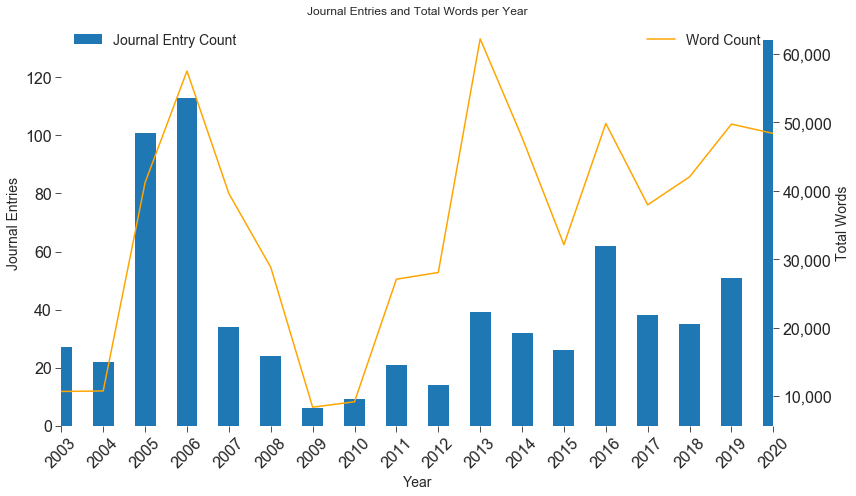

In [8]:
import matplotlib as mpl

style.use('seaborn-ticks')

#same axis
fig, axes = plt.subplots(figsize=(12,7))

ax = entries_per_year.plot(kind='bar', fontsize=14, title ="Journal Entries and Total Words per Year")
ax2 = words_per_year.plot(secondary_y=True, ax=ax, fontsize=16, color='orange')

ax.set_xlabel('Year', fontsize=14)
ax.tick_params(axis='x', rotation=45)

ax.set_ylabel('Journal Entries', fontsize=14)
ax2.set_ylabel('Total Words', fontsize=14)

ax.legend(["Journal Entry Count"], loc='best', prop={"size":14})
ax2.legend(["Word Count"], loc='best', prop={"size":14})

#iterate through axes, to do basic formating
for i, ax in enumerate(fig.axes):
    #add comma
    ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
    #remove spines
    for key, spine in ax.spines.items():
        spine.set_visible(False)
    ax.xlabel = "Year"

fig.tight_layout()

From 2003 to 2010, words / journal entry remained constant.  During this period, the output peaked around 2006 which happened to be a year of transition for me - graduating college, getting a job and moving to San Francisco. Clearly, there were more things to analyze, plan, ruminate about and organize in my journal during this time.  

Additional spikes in word count are in 2013 (traveling for a year, transitioning to a new job) and 2016 (moving to Spain).  

In 2020, a new daily journal format was adopted; 5 minutes of writing every morning - this is reflected in the drastically higher number of entries to date.  

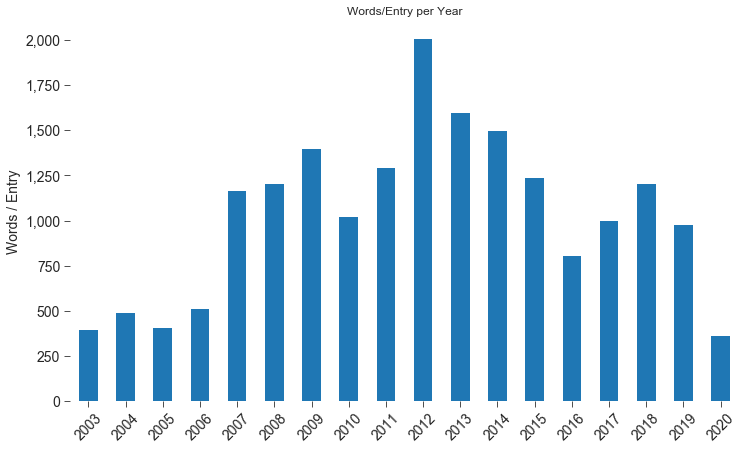

In [9]:
style.use('seaborn-ticks')
fig, axes = plt.subplots(figsize=(12,7))

ax = words_entry_year.plot(kind='bar', fontsize=14, title ="Words/Entry per Year")
ax.set_xlabel('')
ax.set_ylabel('Words / Entry', fontsize=14)
ax.tick_params(axis='x', rotation=45)

#iterate through axes, to do basic formating
for i, ax in enumerate(fig.axes):
    #add comma
    ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
    #remove spines
    for key, spine in ax.spines.items():
        spine.set_visible(False)


In 2012, it's notable that the words/entry increased dramatically - indicating a high number of long journal entries - there were definitely more deep analysis, ruminations, pros/cons lists about important decisions during this time.  2020 indicates the new format of daily 5 minute journals resulting in a sharp decrease in words/entry.

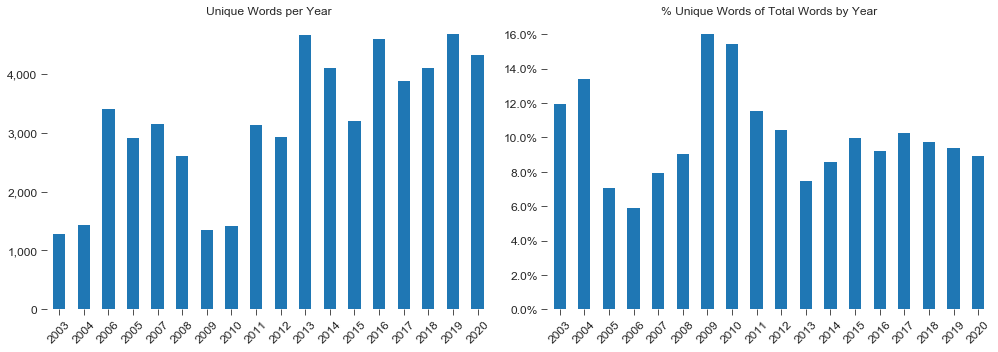

In [10]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14,5))
unique_word_year.plot(kind='bar', title ="Unique Words per Year", fontsize=12, ax=axes[0])
uniques_per_total_words.plot(kind='bar', title ="% Unique Words of Total Words by Year", fontsize=12, ax=axes[1])

#iterate through axes, to do basic formating
for i, ax in enumerate(fig.axes):
    #add comma
    ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
    #remove spines
    for key, spine in ax.spines.items():
        spine.set_visible(False)
    ax.set_xlabel('')
    ax.tick_params(axis='x', rotation=45)
axes[1].yaxis.set_major_formatter(mpl.ticker.PercentFormatter(1))
fig.tight_layout()

The data show a general upward trend of unique word usage as time goes on.  This could indicate an increase in vocabulary as well as a wider variety of experiences to write about. 

The figure on the right shows % unique words of total words, calculated by summing unique words and dividing by total words.  It's essentially a statistic of word repetition - it generally remains constant with notable spikes in 2003/4 and 2009/2010.  Further analysis will be needed to dig into these spikes.  

Let's look at seasonality next - are there dips in frequency of journey entries by month?  Perhaps journaling is more commong in January - due to increased focus on reflection and resolutions.  

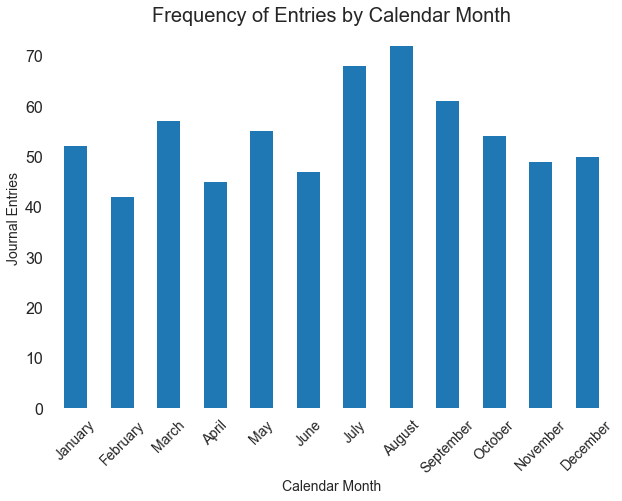

In [11]:
import datetime

#Convert to calendar month
def convert_to_month_name(monthinteger):
    #pdb.set_trace()
    monthinteger = int(monthinteger)
    return(datetime.date(1900, monthinteger, 1).strftime('%B'))

#Exclude 2020 - incomplete year
year_mask = journal_df['year']!='2020'
journal_df_pre_2000 = journal_df[year_mask]

frequency_by_month = journal_df_pre_2000.groupby(journal_df_pre_2000['datetime'].dt.month)['entry'].count()
frequency_by_month = pd.DataFrame(frequency_by_month).reset_index()
frequency_by_month['Month'] = frequency_by_month['datetime'].apply(convert_to_month_name)
frequency_by_month['Month'] = frequency_by_month['datetime'].apply(convert_to_month_name)
frequency_by_month = frequency_by_month.set_index('Month')['entry']

chart = frequency_by_month.plot(kind='bar', figsize=(10, 7), fontsize=16)
plt.title("Frequency of Entries by Calendar Month", fontsize=20)
chart.set_xlabel("Calendar Month", fontsize=14)
chart.set_ylabel("Journal Entries", fontsize=14)
chart.tick_params(axis='x', rotation=45)
chart.tick_params(bottom=False, left=False, top=False, right=False)
for key, spine in chart.spines.items():
    spine.set_visible(False)
     
plt.xticks(fontsize=14)
plt.grid(False)
plt.show(chart)

Frequency of Journal entries by month is relatively constant, with small peaks in the summer months (July/August).  Possibly there was more vacation/traveling during these times, therefore more new experiences to write about. 

# Most Common Words

The first step is to get a general view of the most common words.  We will use the lemmatized version in order to simplify our visualization (went, go, going should all be considered as the verb 'go).

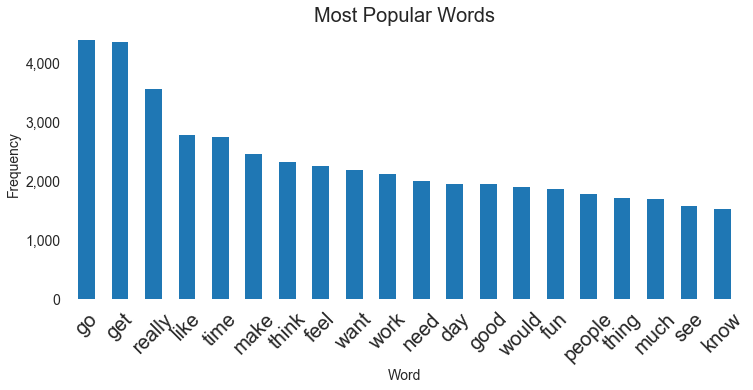

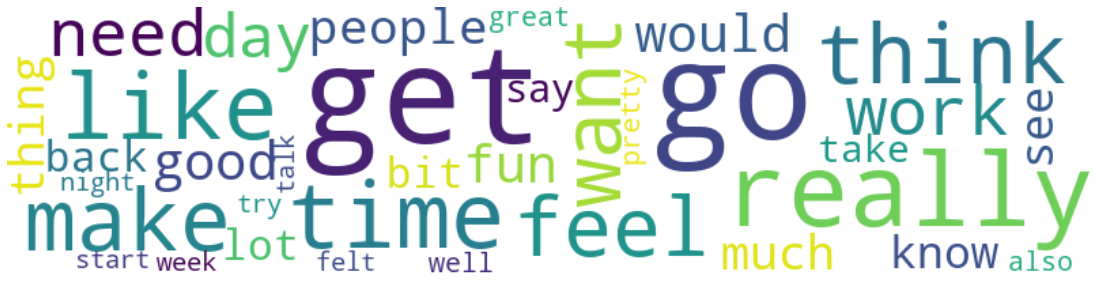

In [12]:
from nltk.corpus import stopwords
from nltk.probability import FreqDist
from wordcloud import WordCloud


#filter out stop words
stop_words = stopwords.words('english')
#Exclude puntuation
punc = string.punctuation
for thing in punc:
    stop_words.append(thing)
stop_words.append('’')
stop_words.append('”')
stop_words.append('“')

#itterate through lemmatized words, create word_list and frequency distribution
word_list =[]
for i, row in journal_df.iterrows():
    for word in row['lemmatized_words']:
        if word not in stop_words:
            word_list.append(word)
fdist = FreqDist(word_list)

#convert fdist to DF
df_fdist = pd.DataFrame.from_dict(fdist, orient='index')
df_fdist.columns = ['Frequency']
df_fdist.index.name = 'Term'
df_fdist.sort_values('Frequency', ascending=False, inplace=True)

#Visualize
chart = df_fdist.head(20).plot(kind='bar', fontsize=14, figsize=(12, 5))
plt.title("Most Popular Words", fontsize=20)
chart.set_xlabel("Word", fontsize=14)
chart.set_ylabel("Frequency", fontsize=14)
chart.tick_params(bottom=False, left=False, top=False, right=False)
for key, spine in chart.spines.items():
    spine.set_visible(False)
plt.grid(False)
plt.xticks(fontsize=20)
chart.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
chart.tick_params(axis='x', rotation=45 )
chart.get_legend().remove()
plt.show(chart)

#Create word cloud
wordcloud = WordCloud(max_words=35, max_font_size=100, width=800, height=200, margin=0, background_color = "white")
wordcloud.generate_from_frequencies(frequencies=df_fdist['Frequency'].to_dict())
plt.figure(figsize=(20,5), )
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

fig.tight_layout()

Top words make sense - holds to logic that they would be used frequently in a journal.

# Parts of Speech and Sentiment

Let's dive a bit deeper into top words and categorize them by the part of speech (verb, noun, proper noun, adjective, adverb).

In [13]:
import nltk

import textblob
from textblob.sentiments import NaiveBayesAnalyzer

stop_words=set(stopwords.words("english"))
pos_list_of_dicts = []

for i, row in journal_df.iterrows():
    paragraph_index = 0
    for paragraph in row['sentences_tokenized']:
        sentence_index = 0
        for sentence in paragraph:
            #remove contractions
            sentence_no_contractions = contractions.fix(sentence)
            #remove puntuation
            sentence_no_contractions = re.sub(r'[^\w\s]','',sentence_no_contractions)
            tokenized_sentence = nltk.word_tokenize(sentence_no_contractions)
            part_of_speech_phrase = nltk.pos_tag(tokenized_sentence)
            
            sentiment = TextBlob(sentence).sentiment
            polarity = sentiment[0]
            subjectivity = sentiment[1]
            #pdb.set_trace()
            lemmatized_word_list = lemmatize_with_postag(sentence_no_contractions)
            d={}
            d['sentence'] = sentence_no_contractions
            d['year']= row.year
            d['subjectivity'] = subjectivity
            d['polarity'] = polarity

            for word, lemmatized_word in zip(part_of_speech_phrase, lemmatized_word_list):
            #for word in part_of_speech_phrase:
                if word[0] not in stop_words and word[0].isalpha():
                    
                    pos_list_of_dicts.append({'word': str.lower(word[0]), 'pos': word[1], 
                                              'row_index' : i, 'paragraph_index' : paragraph_index, 
                                              'sentence_index' : sentence_index,
                                             'sentence' : sentence, 'year' : row.year,
                                             'subjectivity' : subjectivity, 'polarity' : polarity, 'lemmatized_word' : lemmatized_word})

            sentence_index += 1
        paragraph_index += 1    
pos_DF = pd.DataFrame(pos_list_of_dicts)

In [14]:
#Add mapping to pos_DF to indicate general word type
pos_lookup = {
    'NN':'noun', #	noun, singular (cat, tree)
    'NNS':'noun',#	noun plural (desks)
    'NNP':'noun',#	proper noun, singular (sarah)
    'NNPS':'noun', #proper noun, plural (indians or americans)]
    'POS' : 'noun', # possessive ending parent's'
    
    'VB': 'verb',#	verb (ask)
    'VBG': 'verb',#	verb gerund (judging)
    'VBD': 'verb',#	verb past tense (pleaded)
    'VBN': 'verb',#	verb past participle (reunified)
    'VBP': 'verb',#	verb: 'verb', present tense not 3rd person singular(wrap)
    'VBZ': 'verb', #'verb', present tense with 3rd person singular (bases)
    'MD' : 'verb', #modal could, will
    
    'JJ':'adjective',#	adjective (large)
    'JJR':'adjective',#	adjective, comparative (larger)
    'JJS':'adjective',#	adjective, superlative (largest)
    
    'FW':'foreign_word',
    
    'RB':'adverb',#	adverb (occasionally, swiftly)
    'RBR':'adverb',#	adverb, comparative (greater)
    'RBS':'adverb',#	adverb, superlative (biggest)
    
    'NNP':'proper_noun',#	proper noun, singular (sarah)
    'NNPS':'proper_noun',
    'PRP': 'proper_noun', #personal pronoun', I, he, she
    'PRP$': 'proper_noun' # possessive pronoun my, his, hers
}
pos_DF['pos_general'] = pos_DF['pos'].map(pos_lookup)

#aggregate part of speech by pos_general for easy visualization
cleaned_df = pd.DataFrame(pos_DF.groupby(['pos', 'lemmatized_word'])['pos'].count()).rename(columns={'pos':'count'}).reset_index()

nouns=[
'NN',#	noun, singular (cat, tree)
'NNS',#	noun plural (desks)
'NNP',#	proper noun, singular (sarah)
'NNPS',#proper noun, plural (indians or americans)
'POS'
]
nouns_mask = cleaned_df.pos.isin(nouns)
top_nouns = cleaned_df[nouns_mask].groupby('lemmatized_word').sum().sort_values('count', ascending=False)

verbs=[
'VB',#	verb (ask)
'VBG',#	verb gerund (judging)
'VBD',#	verb past tense (pleaded)
'VBN',#	verb past participle (reunified)
'VBP',#	verb, present tense not 3rd person singular(wrap)
'VBZ',#	verb, present tense with 3rd person singular (bases)
'MD']
verbs_mask = cleaned_df.pos.isin(verbs)
top_verbs = cleaned_df[verbs_mask].groupby('lemmatized_word').sum().sort_values('count', ascending=False)
top_verbs.head(40)


adjectives=[
    'JJ',#	adjective (large)
    'JJR',#	adjective, comparative (larger)
    'JJS'#	adjective, superlative (largest)
]
adjectives_mask = cleaned_df.pos.isin(adjectives)
top_adjectives = cleaned_df[adjectives_mask].groupby('lemmatized_word').sum().sort_values('count', ascending=False)
top_adjectives.head(40)

foreign_word=[
    'FW'
]
FW_mask = cleaned_df.pos.isin(foreign_word)
top_FW = cleaned_df[FW_mask].groupby('lemmatized_word').sum().sort_values('count', ascending=False)
top_FW.head(40)

adverbs = [
'RB',#	adverb (occasionally, swiftly)
'RBR',#	adverb, comparative (greater)
'RBS',#	adverb, superlative (biggest)
]

adverbs_mask = cleaned_df.pos.isin(adverbs)
top_adverbs = cleaned_df[adverbs_mask].groupby('lemmatized_word').sum().sort_values('count', ascending=False)
top_adverbs.head(40)

proper_nouns=[
'NNP',#	proper noun, singular (sarah)
'NNPS',#proper noun, plural (indians or americans)
#'PRP',
'PRP$'
]
proper_nouns_mask = cleaned_df.pos.isin(proper_nouns)
top_proper_nouns = cleaned_df[proper_nouns_mask].groupby('lemmatized_word').sum().sort_values('count', ascending=False)

#combine everything
top_nouns['type'] = 'noun'
top_verbs['type'] = 'verb'
top_adjectives['type'] = 'adjective'
top_adverbs['type'] = 'adverbs'
top_proper_nouns['type'] = 'proper_noun'

top_words_pos = pd.concat([top_nouns, top_verbs, top_adjectives, top_adverbs, top_proper_nouns])

NOUNS:


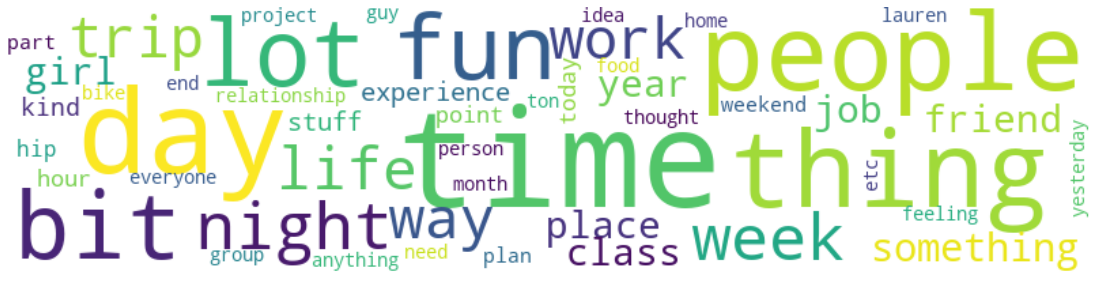

In [15]:
print('NOUNS:')
wordcloud = WordCloud(max_words=50, max_font_size=100, width=800, height=200, margin=0, background_color = "white")
wordcloud.generate_from_frequencies(frequencies=top_nouns['count'].to_dict())
plt.figure(figsize=(20,5), )
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

The wordcloud gives an interesting perspective into whatis important in my life: people, time and fun!

VERBS:


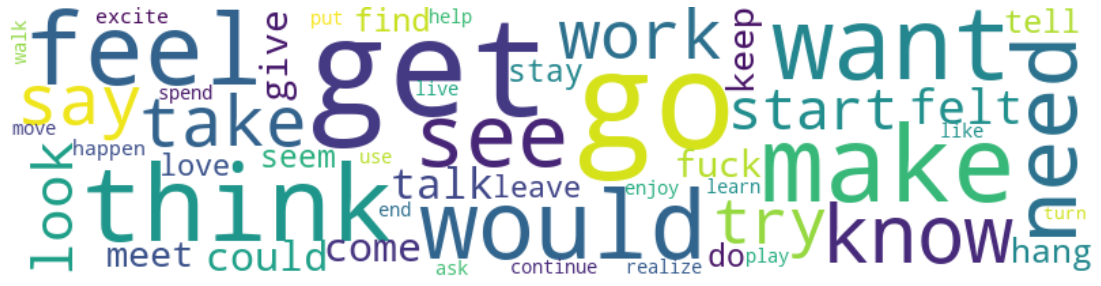

In [16]:
print('VERBS:')
wordcloud = WordCloud(max_words=50, max_font_size=100, width=800, height=200, margin=0, background_color = "white")
wordcloud.generate_from_frequencies(frequencies=top_verbs['count'].to_dict())
plt.figure(figsize=(20,5), )
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

Verbs of introspection: think, want, feel, know, need, know. 

ADJECTIVES:


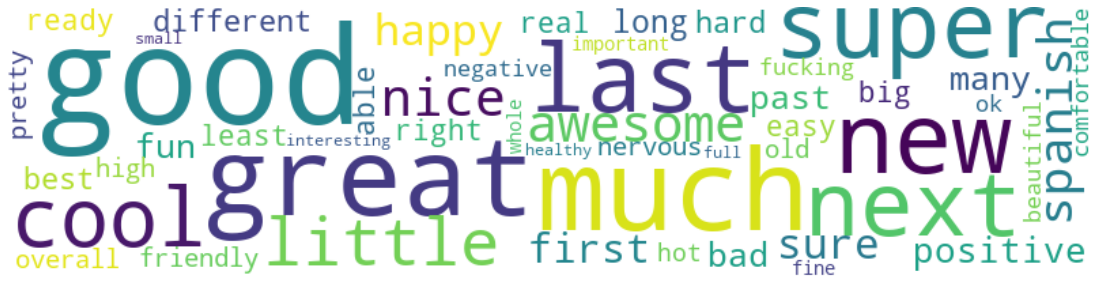

ADVERBS:


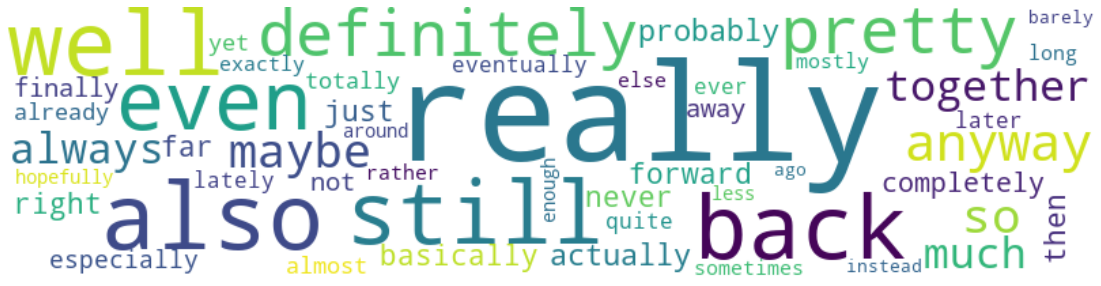

In [17]:
print('ADJECTIVES:')
wordcloud = WordCloud(max_words=50, max_font_size=100, width=800, height=200, margin=0, background_color = "white")
wordcloud.generate_from_frequencies(frequencies=top_adjectives['count'].to_dict())
plt.figure(figsize=(20,5), )
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

print('ADVERBS:')
wordcloud = WordCloud(max_words=50, max_font_size=100, width=800, height=200, margin=0, background_color = "white")
wordcloud.generate_from_frequencies(frequencies=top_adverbs['count'].to_dict())
plt.figure(figsize=(20,5), )
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

Mostly positive adjectives and adverbs: good, great, awesome, super, nice.  I think this reflects my generally positive nature!

PROPER_NOUNS:


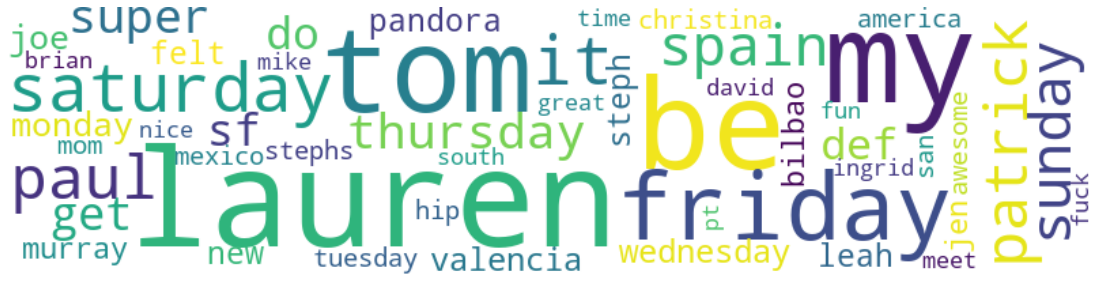

In [18]:
print('PROPER_NOUNS:')
wordcloud = WordCloud(max_words=50, max_font_size=100, width=800, height=200, margin=0, background_color = "white")
wordcloud.generate_from_frequencies(frequencies=top_proper_nouns['count'].to_dict())
plt.figure(figsize=(20,5), )
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

Places that I've lived, family members, ex-girlfriends, days of the week.  Nothing too surprising here.  Some notes on proper noun tagging issues:
* If sentence is started with verb suth as 'Got', 'Def', 'Felt' - it is wrongly classified as proper noun.  
* If the name is not capitalized, it is classified as noun.  For example, there are many entires of 'mom' and they are all classified as nouns.

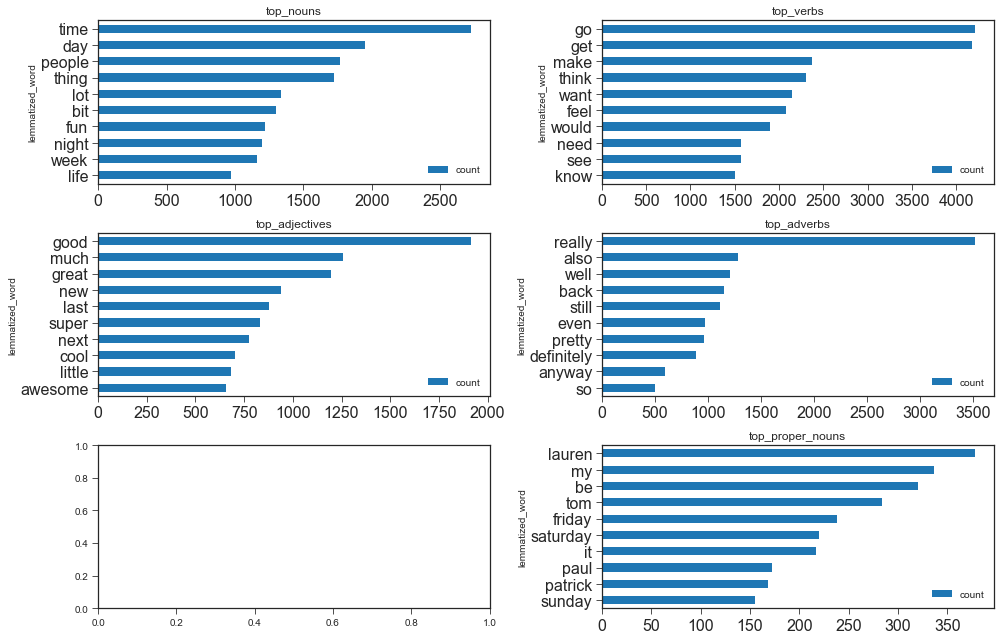

In [19]:
#GRAPHS
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(14,9))


top_nouns.head(10).sort_values('count', ascending=True).plot(kind='barh', title ="top_nouns", fontsize=16, ax=axes[0,0])
top_verbs.head(10).sort_values('count', ascending=True).plot(kind='barh', title ="top_verbs", fontsize=16, ax=axes[0,1])
top_adjectives.head(10).sort_values('count', ascending=True).plot(kind='barh', title ="top_adjectives", fontsize=16, ax=axes[1,0])
top_adverbs.head(10).sort_values('count', ascending=True).plot(kind='barh', title ="top_adverbs", fontsize=16, ax=axes[1,1])
top_proper_nouns.head(10).sort_values('count', ascending=True).plot(kind='barh', title ="top_proper_nouns", fontsize=16, ax=axes[2,1])

fig.tight_layout()

# Most common n-grams

N-grams are defined as "a contiguous sequence of n items from a given sample of text or speech."  Essentially, it is a series of N continuous words in a text.  Let's do some basic n-gram analysis on the journal to see if any interesting patterns emerge.  

Read more here: https://en.wikipedia.org/wiki/N-gram

In [20]:
from nltk import ngrams
import pdb

def n_grams_function(journal_df, n=2):
    grams_list = []
    for i, row in journal_df.iterrows():
        for paragraph in row['sentences_tokenized']:
            for sentence in paragraph:
                sentence = re.sub(r'[^\w\s]','',sentence)
                tokenized_sentence = nltk.word_tokenize(str.lower(sentence))
                grammed_sentence = ngrams(tokenized_sentence, n)
                for gram in grammed_sentence:
                    grams_list.append(gram)
    grams_df = pd.DataFrame(grams_list)
    n_gram_combined_list=[]
    test = pd.DataFrame(grams_list)
    for i, row in test.iterrows():
        n_gram = ''
        for word_position in range(0,n):
            word = row.iloc[word_position]
            n_gram = n_gram + ' ' + word
        n_gram_combined_list.append(n_gram)    
    return pd.DataFrame(n_gram_combined_list)  

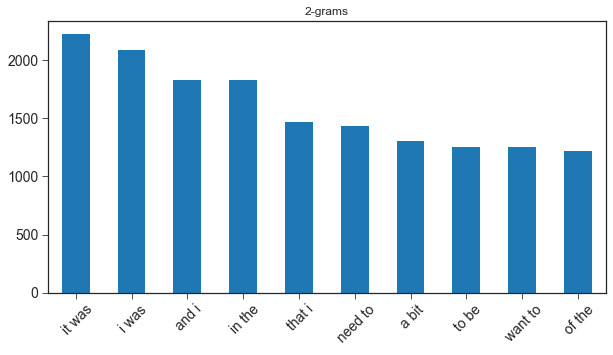

In [21]:
two_grams_df_with_function = n_grams_function(journal_df, n=2)
two_grams_top_10 = two_grams_df_with_function[0].value_counts().head(10).index.to_list()
pd.DataFrame(two_grams_df_with_function[0].value_counts()).head(10)
two_grams_df_with_function[0].value_counts()[:10].plot(title='2-grams', kind='bar', figsize=(10,5), rot=45, fontsize=14)

Nothing too interesting with the bi-grams.  

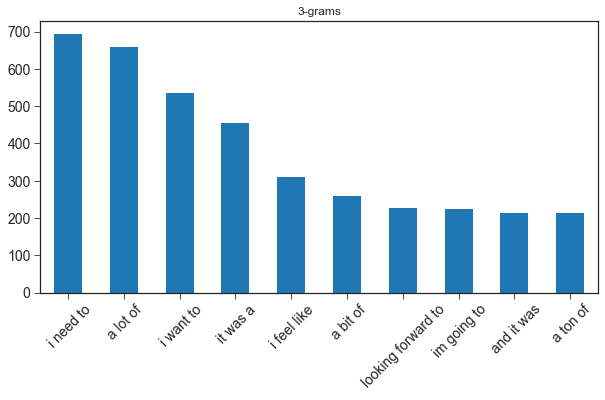

In [22]:
three_grams_df_with_function = n_grams_function(journal_df, n=3)
three_grams_top_10 = three_grams_df_with_function[0].value_counts().head(10).index.to_list()
pd.DataFrame(three_grams_df_with_function[0].value_counts()).head(10)
three_grams_df_with_function[0].value_counts()[:10].plot(title='3-grams', kind='bar', figsize=(10,5), rot=45, fontsize=14)

Starting to get interesting.  Phrases like "I need to" and "I want to" reveal recurring thoughts, desires and plans.  It would be interesting to dig into these bigrams further - what are common words that come after them?  

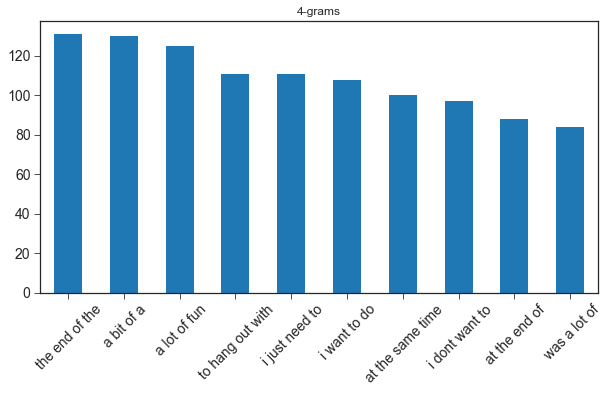

In [23]:
four_grams_df_with_function = n_grams_function(journal_df, n=4)
four_grams_top_10 = four_grams_df_with_function[0].value_counts().head(10).index.to_list()
pd.DataFrame(four_grams_df_with_function[0].value_counts()).head(10)
four_grams_df_with_function[0].value_counts()[:10].plot(title='4-grams', kind='bar', figsize=(10,5), rot=45, fontsize=14)

Plenty of additional roads to investigate.  For example, I mention 'a lot of fun' over 100 times - what is a lot of fun?  What are the common nouns that are associated with this 4-gram?

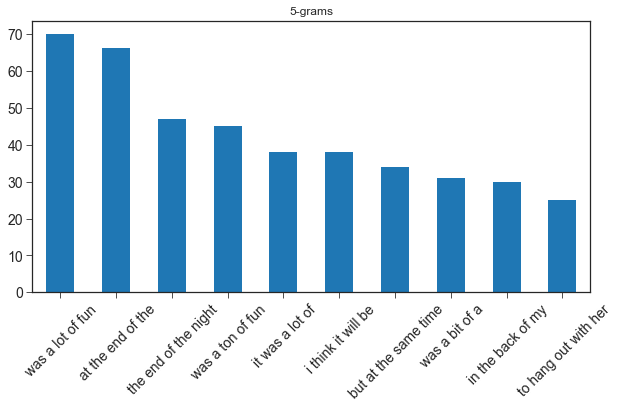

In [24]:
five_grams_df_with_function = n_grams_function(journal_df, n=5)
five_grams_top_10 = five_grams_df_with_function[0].value_counts().head(10).index.to_list()
pd.DataFrame(five_grams_df_with_function[0].value_counts()).head(10)
five_grams_df_with_function[0].value_counts()[:10].plot(title='5-grams', kind='bar', figsize=(10,5), rot=45, fontsize=14)

Interesting to see that 'but at the same time' was written over 40 times - it's presence indicates a contrast of sorts - perhabs a positive and negative thought in the same sentence?  It's a perfect example of how messy it is to analyze text: oftentimes, a single sentence or phrase cannot be easily classified as 100% positive or negative.  

# Phrase Generator 

The phrase generator picks a common n-gram and outputs sentences using that n-gram, picking a random one for each year.  Its purpose is to dig into what common themes are associated with a given n-gram.  
  

In [25]:
import random
def phrase_generator(interesting_grams, return_one_random_match=True):
    number_grams = len(interesting_grams) -1
    phrase = interesting_grams[random.randint(0,number_grams)]
    list_dicts=[]
    d={}
    for i, row in journal_df.iterrows():
        for paragraph in row['sentences_tokenized']:
            for sentence in paragraph: 
                #remove puntuation
                sentence_no_punc = re.sub(r'[^\w\s]','',sentence)
                pattern = phrase
                match = re.search(pattern, sentence_no_punc, flags=re.IGNORECASE)
                if match:
                    start=match.span()[0]
                    d={}
                    d['year']= row.year
                    d['sentence'] = sentence[start:]
                    list_dicts.append(d)
                else:
                    continue
    phrases_by_year=pd.DataFrame(list_dicts)
    if return_one_random_match==True:
        phrases_by_year = phrases_by_year.sort_values('year').groupby('year').agg(np.random.choice)
        print(str.upper(phrase) + '...')
        print('------------------------------------------------------------------')
        return phrases_by_year.style.set_properties(**{'text-align': 'left'})
    else:
        print(str.upper(phrase) + '...')
        print('------------------------------------------------------------------')
        phrases_by_year = phrases_by_year.sort_values('year')
        return phrases_by_year

In [26]:
#n-grams related to regret, desire, feelings, emotions
deep_dive_phrases= ['i need to', 'i just need to',
                    'i want to', 'i really want to', 'i dont want to',
                    'im going to', 'it will be',
                    'i feel like', 
                    'im looking forward', 
                    'im looking forward to',
                    'i should have', 'i shouldnt have',
                    'i think it', 'i think it will be'
                   'and she was',
                   'a bit of a',
                   'but at the same time',
                   'at the end of the day', 'make more of an effort to']
phrase_generator(deep_dive_phrases)

I DONT WANT TO...
------------------------------------------------------------------


,sentence
year,
2003,I don’t want to end up like a piece of shit recluse alcoholic asshole like my dad.
2004,I don’t want to stop now.
2005,I don’t want to get too busy and not give myself time to work on my personal stuff.
2006,I don’t want to be in a lab or in production.
2007,I don’t want to have to rely on drinking to feel comfortable.
2008,I don’t want to be defined by someone else.
2010,I don't want to take the lead myself...too many flakes out there.
2011,I don’t want to lose her but this is something that I want to do and I don’t think a girl can stop me.
2012,I don’t want to do this trip by myself.


# Sentiment Analysis

Sentiment analysis is an NLP technique to quantify the emotional state of text.  It leverages machine learning principles and a common methodology is to classify the text as positive or negative.  Textblob provides a 'polarity score' of sentiment, which is afloat within the range [-1.0, 1.0] - negative values indicate negative sentiment and positive indicate positive sentiment.  

From the docs(https://github.com/sloria/TextBlob/blob/eb08c120d364e908646731d60b4e4c6c1712ff63/docs/advanced_usage.rst):

*The textblob.sentiments module contains two sentiment analysis implementations, PatternAnalyzer (based on the pattern library) and NaiveBayesAnalyzer (an NLTK classifier trained on a movie reviews corpus).

*The default implementation is PatternAnalyzer, but you can override the analyzer by passing another implementation into a TextBlob's constructor.


**NLKT Classifier:**

* https://www.nltk.org/book/ch06.html
* Supervised classification - based on corpus of training data

Let's start off by calculating the polarity of each sentence and journal entry.    

In [27]:
#by entry
sentiment_list = []
for i, row in journal_df.iterrows():
    #join all paragraphs into single string
    journal_entry_string = ' '.join(row['entry'])
    sentiment = TextBlob(journal_entry_string).sentiment
    polarity = sentiment[0]
    subjectivity = sentiment[1]
    d={}
    d['entry'] = journal_entry
    d['year']= row.year
    d['subjectivity'] = subjectivity
    d['polarity'] = polarity
    d['index'] = i
    d['datetime'] = row.datetime
    sentiment_list.append(d)
sentiment_by_entry_df = pd.DataFrame(sentiment_list)
#add calendar month column
sentiment_by_entry_df['month_integer'] = sentiment_by_entry_df['datetime'].dt.month
sentiment_by_entry_df['month_name'] = sentiment_by_entry_df['month_integer'].apply(convert_to_month_name)

#by sentence
sentiment_list = []
for i, row in journal_df.iterrows():
    for paragraph in row['sentences_tokenized']:
        for sentence in paragraph:
            sentiment = TextBlob(sentence).sentiment
            polarity = sentiment[0]
            subjectivity = sentiment[1]
            d={}
            d['sentence'] = sentence
            d['year']= row.year
            d['subjectivity'] = subjectivity
            d['polarity'] = polarity
            d['index'] = i
            d['datetime'] = row.datetime
            sentiment_list.append(d)
            #pdb.set_trace()
sentiment_by_sentence_df = pd.DataFrame(sentiment_list)

NameError: name 'journal_entry' is not defined

5 random sentences with the highest positive sentiment polarity:

In [ ]:
cl = sentiment_by_sentence_df.loc[sentiment_by_sentence_df.polarity == 1, ['sentence']].sample(5).values
for c in cl:
    print(c[0])


Some examples of the output - all seem pretty positive to me:

* Neither my hip nor knee hurt...was awesome!
* Man I just had the thought that I’m one of the best people at Excel in the office.
* We went to Morton’s and the food was delicious.
* Awesome group we have.
* It was awesome.
* For me, those are the best.
* It’s just the perfect atmosphere for it.

Apparently, 'awesome' is one of my favorite words and I high predictor of positive polarity.

5 random sentences with full most negative sentiment polarity:

In [ ]:
cl = sentiment_by_sentence_df.loc[sentiment_by_sentence_df.polarity <-.9, ['sentence']].sample(5).values
for c in cl:
    print(c[0])

Some examples of the output that are clearly negative:

* I went to a musuem in the worst town ever (Lambayugua or something).
* I hate losing!
* I was in an awful mood.
* Then we went to this horrible breakfast at 7 am.

However, there were several sentences that were not necessarily negative, yet got classified as fully negative (-1.0):

* The nightlife here is insane - the bar didn’t close until 5AM!
* Wrote a script that wasn’t terrible and could use some work - I should keep iterating on it.

In [ ]:
import seaborn as sns
plt.figure(figsize=(10,7))

chart = sns.distplot(sentiment_by_entry_df['polarity'], kde=False, color='green', bins=20)
plt.title('Sentiment Polarity Distribution', fontsize=18)
plt.xlabel('Sentiment Polarity Score', fontsize=16)
plt.ylabel('count', fontsize=16)
# figure size in inches
#sns.set(rc={'figure.figsize':(14,10)})

#chart.set_xlim(0,35)

sns.set(style="whitegrid")
for key, spine in chart.spines.items():
    spine.set_visible(False)
plt.grid(False)


In [ ]:
#ENTRY
mean_sentiment = sentiment_by_entry_df.groupby('year')['polarity'].agg(['mean'])

chart = mean_sentiment.plot(kind='bar', figsize=(12, 8), fontsize=12)
plt.title("Mean Sentiment Polarity by Year", fontsize=20)

chart.set_xlabel("", fontsize=14)
chart.tick_params(axis='x', rotation=45)
plt.xticks(fontsize=14)

chart.set_ylabel("Sentiment Polarity Score (mean)", fontsize=14)
chart.tick_params(bottom=False, left=False, top=False, right=False)
for key, spine in chart.spines.items():
    spine.set_visible(False)
    
chart.get_legend().remove()
plt.grid(False)
plt.show(chart)


In [ ]:
plt.figure(figsize=(12,9))
ax = sns.boxplot( y="polarity", x='year', data=sentiment_by_entry_df)
#ax.set_ylim([4,25])
plt.title('Sentiment Polarity Distribution by Year', fontsize=18)
#plt.xlabel('# of Ratings Group', fontsize=16)
plt.ylabel('Sentiment Polarity Score', fontsize=16)
plt.xlabel('')

ax.tick_params(axis='x', rotation=45)
plt.xticks(fontsize=14)

for key, spine in ax.spines.items():
    spine.set_visible(False)
plt.grid(False)

In [ ]:
sentiment_by_entry_df.head()

In [ ]:
#Sentiment Polarity by calendar month - changes in seasonality?
#Convert to calendar month






In [ ]:
sentiment_by_entry_df[['year', 'polarity', 'datetime', 'month']]
seddntiment_by_entry_df['month_integer'].value_counts()


In [ ]:
polarity_monthly_series = sentiment_by_entry_df.groupby(['month_integer', 'month_name'])['polarity'].mean().reset_index('month_integer')['polarity']

mean_sentiment = sentiment_by_entry_df.groupby('year')['polarity'].agg(['mean'])

chart = polarity_monthly_series.plot(kind='bar', figsize=(12, 8), fontsize=12)
plt.title("Mean Sentiment Polarity by Calendar Month", fontsize=20)

chart.set_xlabel("", fontsize=14)
chart.tick_params(axis='x', rotation=45)
plt.xticks(fontsize=14)

chart.set_ylabel("Sentiment Polarity Score (mean)", fontsize=14)
chart.tick_params(bottom=False, left=False, top=False, right=False)
for key, spine in chart.spines.items():
    spine.set_visible(False)
    
plt.grid(False)
plt.show(chart)

# Polarity by top POS - mean

In [ ]:
def get_polarity_by_top_x(reference_POS_df, POS_individual_df, part_of_speech_name, top_x):
    top_POS_list = POS_individual_df[:top_x].index.to_list()
    print(top_POS_list)
    mask = reference_POS_df.lemmatized_word.isin(top_POS_list)
    #polarity_summary = reference_POS_df[mask].groupby('word')['polarity'].mean().sort_values()
    polarity_summary = reference_POS_df[mask].groupby('lemmatized_word')['polarity'].mean().sort_values()
    #lemmatized_word
    
    plt.figure(figsize=(10,8))
    chart = sns.barplot(y=polarity_summary.index, x=polarity_summary.values, alpha=0.9, color='lightgreen')
    title = 'Polarity of Top ' + part_of_speech_name
    plt.title(title, fontsize=15)
    plt.ylabel(part_of_speech_name, fontsize=15)
    plt.xlabel('Polarity', fontsize=15)
    plt.yticks(fontsize=13)

    plt.grid(False)
    for key, spine in chart.spines.items():
        spine.set_visible(False)

    plt.show()

In [ ]:
get_polarity_by_top_x(pos_DF, top_nouns, 'Nouns', 10)

In [ ]:
get_polarity_by_top_x(pos_DF, top_proper_nouns, 'Proper Nouns', 15)

In [ ]:
get_polarity_by_top_x(pos_DF, top_verbs, 'Verbs', 20)

Notes:
* "Made" is CREATING - those things are highly positive.  Creativity!

In [ ]:
get_polarity_by_top_x(pos_DF, top_adjectives, 'Adjectives', 20)

Notes:

* Past and little - interesting that they are heading into negative territory.  Looking into the past is more likely to cause negative thoughts?
* Awesome seems to drive up polarity quite a bit.  Would be interesting to know how it's actually calculated behind the hood.  

In [ ]:
get_polarity_by_top_x(pos_DF, top_adverbs, 'Adverbs', 20)

# Polarity by top POS - BOXPLOTS

In [ ]:
def get_polarity_by_top_x_box_plot(reference_POS_df, POS_individual_df, part_of_speech_name, top_x):
    top_POS_list = POS_individual_df[:top_x].index.to_list()
    print(top_POS_list)
    mask = reference_POS_df.lemmatized_word.isin(top_POS_list)
    polarity_summary = reference_POS_df[mask]
    plt.figure(figsize=(12,9))
    ax = sns.boxplot( y="polarity", x="lemmatized_word", data=polarity_summary)
    #ax.set_ylim([4,25])
    title= 'Polarity by ' + part_of_speech_name
    plt.title(title, fontsize=18)
    plt.xlabel('Word', fontsize=16)
    plt.ylabel('Polarity', fontsize=16)
    ax.tick_params(axis='both', which='major', labelsize=19)
    for key, spine in ax.spines.items():
        spine.set_visible(False)
    plt.grid(False)

    plt.show()

In [ ]:
get_polarity_by_top_x_box_plot(pos_DF, top_nouns, 'Nouns', 10)

In [ ]:
get_polarity_by_top_x_box_plot(pos_DF, top_proper_nouns, 'Proper Nouns', 10)

# Random Stuff to look into


Not seeing much correlation between increasing sentence length and higher 0 polarity

In [ ]:
#sentiment_by_sentence_df['polarity'].hist()

chart = sns.distplot(sentiment_by_sentence_df['polarity'], kde=False, color='green', bins=100)

plt.title('sentiment_by_sentence_df', fontsize=18)
plt.xlabel('Sentiment', fontsize=16)
plt.ylabel('count', fontsize=16)
# figure size in inches
sns.set(rc={'figure.figsize':(14,10)})

#chart.set_xlim(0,35)

sns.set(style="whitegrid")
for key, spine in chart.spines.items():
    spine.set_visible(False)
plt.grid(False)


In [ ]:
#divide into 0 and non-0
example = sentiment_by_sentence_df[sentiment_by_sentence_df.polarity == 0].iloc[1].sentence
#example = 'I continue on towards the escalator when I hear a crazy yell out my name.  .'
print(example)
print(TextBlob(example).sentiment)

* Note to self: I should do a "how good is textblog analysis" - it looks to have a lot of shortcomings.  Compare it with other methodologies!  https://medium.com/@Intellica.AI/vader-ibm-watson-or-textblob-which-is-better-for-unsupervised-sentiment-analysis-db4143a39445


* **(5)** I wonder if we could look at tenses - which tense is the most common?


# Make my own classifier 

According to this blog (http://blog.chapagain.com.np/python-twitter-sentiment-analysis-using-textblob/) - You can import a twitter data set.  Gave me an idea: I have my own journal sentences tagged as positive / negative - I can run a simple test with each classifier (my own, twitter, native) and output accuracy - then use the most accurate.  Machine learning!

* https://textblob.readthedocs.io/en/dev/classifiers.html
* https://streamhacker.com/2010/05/10/text-classification-sentiment-analysis-naive-bayes-classifier/
* https://streamhacker.com/2010/06/16/text-classification-sentiment-analysis-eliminate-low-information-features/


In [ ]:
# testing different analyzers

def test_analyzer(text, analyzer='NaiveBayesAnalyzer'):
    if analyzer=='NaiveBayesAnalyzer':
        sample_text = TextBlob(text, analyzer=NaiveBayesAnalyzer())
        print('Bayes:')
        print(sample_text.sentiment)
        return sample_text.sentiment
    else:
        sample_text = TextBlob(text)
        print('Default:')
        print(sample_text.sentiment_assessments)
        return sample_text.sentiment_assessments

In [ ]:
text = 'Decided to take a break from cycling today.  I was feeling a bit burnt out on it - going through the routine and not getting as much joy from it.  I’m glad I switched it up!  Went for a nice camino to the beach and back - about an hour.  Listening to some inspiring podcasts, taking in the tranquility of the morning, seeing the sun rise, sharing it with strangers, observing the beauty of Calle Puerto.  Walking really does wonders to clear my mind. '
text = 'After our really productive chat about the future, we went right into a photography project of her jewelry.  It was so much fun!  In the flow zone, experimenting with light, backgrounds, angles, etc.  Getting feedback from Steph was great and feeling like i had a job, a duty, a goal.  It was a super neat challenge, flexing creative muscles, doing photography, which I love and producing an awesome end product!  We made tons of really cool photos - the leaves, her jewelry in tons of different angles and lighting situations, then did some cool BTS shots and the “La Cova Fosca” manuscript covered in leaves and twigs.  So neat and fun.  '
text = 'A bit discouraged on job app process.  Not seeing a lot, stuff here and there. I’ve heard it’s becoming harder, less jobs, more tightening.  Feeling negativity creep in.'
text = 'I feel like shit.'

analyzer='NaiveBayesAnalyzer'
bayes = test_analyzer(text, analyzer='NaiveBayesAnalyzer')
default = test_analyzer(text, analyzer='default')

NaiveBayesAnalyzer says "I feel like shit" is positive and the default ranks it as mildly negative.  I should build my own Classification.  Here are some ideas:
* Using top X parts of speech (noun, verbs, etc.) - get x random sentences for each one.
* Manually classify them as positive or negative.  

In [ ]:
top_words_pos.type.value_counts()

In [ ]:
#groupby and then grab random selection of rows
pos_DF.groupby('year')['sentence'].apply(lambda x: x.sample(2))


LEFT OFF HERE.  NEXT STEPS:
* Build out test sentences - almost finsihed with function below.
* Figure out good way to classify them as negative or positive.


In [ ]:
training_df.iloc[:1,:]

In [ ]:
#get top 10 words * each part of speech (5) * 10 random sentences for each word : 500 sentences to classify
training_df = top_words_pos.sort_values(['type', 'count'], ascending=[False, False]).groupby('type').head(10)

#create blank DF with desired columns
sample_sentence_df = pd.DataFrame(columns= ['year', 'sentence', 'word', 'pos_general'])

#for each word, one random sentence / year
for index, row in training_df.iterrows():
    word = index
    pos_general = row.type
    
    mask = (pos_DF.word==word) & (pos_DF.pos_general==pos_general)
    # allows for 1 random choice only: pos_DF[mask].groupby('year')['sentence'].agg(np.random.choice)
    current_sample_sentence_df = pd.DataFrame(pos_DF[mask].groupby('year')['sentence'].apply(lambda x: x.sample(1))).reset_index()
    current_sample_sentence_df['word'] = word
    current_sample_sentence_df['pos_general'] = pos_general
    
    if 'level_1' in current_sample_sentence_df.columns:
        current_sample_sentence_df = current_sample_sentence_df.drop('level_1', 1)
    #join to previous
    sample_sentence_df = pd.concat([sample_sentence_df, current_sample_sentence_df])


In [ ]:
for sentence in sample_sentence_df.iloc[130:140,:].sentence:
    print("('" + re.sub("'", '', sentence ) + "', '?'),")

Ok - I hvae 694 sentences to classify.  I wonder how long it will take.  I should find a way to operationalize it.  Make it quick.  
* Operationalize it.
* What to do in cases when it's not a clear positive or negative?
* should I look into doing it by paragraph?  Pros - more context.  Cons - could be long and time consuming to read.  

# Testing Classifier


In [ ]:
train = [
    ('Like I have told myself too many times, I let other people effect me way too much, I get put in a really good mood when something good happens to me like say a girl likes me and then I get in a really bad mood when something negative happens, I have to be more constant with how I feel.', 'NEG'),
('The whole “get as much ass as possible” attitude is no longer in affect.', 'POS'),
('Not soley because we were wounded as children all children get wounded but because as children we rarely get to mourn the most difficult hurts and losses.', 'NEG'),
('Anyway, after that, I went to go get my oil changed and read over my green binder, looking at past transcripts.', 'NEUTRAL'),
('Anyway, I found out that I did not get the DM job.', 'NEG'),
('I think that part of the anxiety that comes up when I get close to girls is that I forget about myself in the process, because I’m so fixated on them and their response.', 'NEG'),
('Ninety Five percent of the time, Matt and I get along great.', 'POS'),
('I feel like its better for me to express my feelings rather than hold it in and try and fake it and pretend like Im not upset, although the fact that we are apart makes it more complicated...its harder to get over these stupid arguments when were not together.', 'NEG'),
('Slight feelings of jealousy crop up and I start to get pissed off at the thought of them making out on the roof without involving me.', 'NEG'),
('I busted my ass to get out an intial ad load analysis, but it’s been stalled for hte past few weeks due to month end metrics and decks.', 'NEG'),
('In retrospect it’s almost always better to get it out when it comes to that point.', 'POS'),
('Definitely a bright spot my otherwise cloudy world (right now, I know it will get better soon).', 'POS'),
('It helped me get on track to be more grounded - get a job, get an apartment, be stable.', 'POS'),
('I told her that at times I like to be a bit more disconnected (which is true) and that I was consciously holding back because I didn’t want things to go to fast or get too intense (I think I told her this)', 'POS'),
('Hold off on train ticket well to get to Barna', 'NEUTRAL'),
('Met up with Laura and she convinced me to stay with her - I was able to get a refund on the hostel.', 'NEUTRAL'),
('Especially since I need to get up super early the next day.', 'NEUTRAL'),
('Today, hoping for a bit more structure, do some data projects, get stuff done, feel productive.', 'NEUTRAL'),
('I also found out this week that other people such as max and Charlie have a problem with Jon and think I should fight him.', 'NEG'),
('She’s still trying to get a job and I’m happy that she is I think it will be really good for her.', 'POST'),
('I’m trying to give her subtle hints that I’m interested, besides the fact that I keep asking her to do stuff, I try and be flirtacious and suggestive so that hopefully she can get the picture which I think she does.', 'NEUTRAL'),
('Anyway, I know what I need to do to get back on track: think about the collage, look over transcripts, think about things I have to be proud of, get stuff done (clean room, dishes, etc.)', 'NEG'),
('Maybe she’s just a friendly person but I really think she is into me based on her body language and attitude.', 'POS'),
('I’ve been forcing myself to run/work out more often as of late and I think that’s helping elevate my mood with endorphin production.', 'POS'),
('I know its not a good idea to introduce that shit into my system, but honestly I don’t think it’s a big deal.', 'NEG'),
('I think that it could only turn out badly.', 'NEG'),
('I think we sort of fell into this rut where it was more an obligation than anything else and it stopped being fun.', 'NEG'),
('We’ve had our near fights but I think communication and expectation setting are key.', 'NEUTRAL'),
('Like I said, I think it REALLY helps that Lauren has her Yoga and is really into experimenting with cooking (while doing it within the budge).', 'POS'),
('It was very challenging to ride the bike - definitely will take some getting used to, but I don’t think I’ll have a problem.', 'POS'),
    
('But, I didn’t think there was anything tangible to change...what would we do...plan more events together?', 'NEUTRAL'),
('But in practice, I don’t think this will work.', 'NEG'),
('The temptation and ease of living together is definitely there, but I dont’ think it would be setting us up for success.', 'NEG'),
('Maybe think about investing in a heat pack.', 'NEUTRAL'),
('Does he think I´m stupid?!?', 'NEG'),
('I think twice a week is pretty good - the variety is important.', 'POS'),
('Going to the park, tanning, going to the rec hall, play Frisbee.', 'POS'),
('borrow Davids car and go over and she tells her roomates that we are going to watch a movie.', 'NEUTRAL'),
('We ended up going out to eat at in n out which was fun.', 'POS'),
('Also I think in the back of my mind I’m going to use the day as sort of a gauge to my self worth based on other people involvement I guess….', 'NEG'),
('I am going to get a copy of mediation for dummies and really start to work on it.', 'POS'),
('I’m glad I’m still going, but I feel like it’s much less of a priority now that Leah is in my life.', 'NEUTRAL'),
('Early on in our relationship she told me how she had SO MANY friends in the city and how it was going to be hard to invite everyone to her wedding.', 'NEG'),
('Hes going to do well in college.', 'POS'),
('I almost have too many trips going on!', 'POS'),
('I bused over late Friday to see her and even though I was exhuasted (from an awesome week playing hoops for the first time in ages and going to a CAL bball game) and I had such a great night.', 'POS'),
('   * Def opened up to each other and related to shit we were going through.', 'POS'),
('I think that as long as I’m clear on my expectations and space, there is no problem in going down that path.', 'POS'),
('I’m exploring going down the surgery route with both Sampson and Safron.', 'NEUTRAL'),
('Very cool chicks, ended up going to a modern dance performance in a cultural center.', 'POS'),

('He’s going to be a great Dad.', 'POS'),
('I’m not going to rush.', 'NEUTRAL'),
('Still feeling great about how things are going and I’m not going to give too much weight to this.', 'POS'),
('Going to  a swing event and meeting up with Leyre today.', 'NEUTRAL'),
('Do you want me to go down on your or have sex?', 'NEUTRAL'),
('I stopped going to practices and stopped working out because I didn’t want to do any further damage to it.', 'NEG'),
('together which could make things awkward, I dont want to have to worry', 'NEG'),
('She said of course you don’t want to come home, who would, and she got a little broken up about it.', 'NEG'),
('Its not something that I would want to do, but it was fun meeting with the guy none the less.', 'POS'),
('I really do want to find someone that I like.', 'NEUTRAL'),
('I want to take it to the next level and figure out how to load in real Pandora data and then be able to pull custom queries that wouldnt work on excel or DFPs query tool.', 'POS'),
('I also want to start a little garden in the backyard.', 'NEUTRAL'),
('And more importantly, I want to have more adventures.', 'POS'),
('I also want that tripod for my camera.', 'POS'),
('I want to keep doing couchsurfing...next time I’m going to be a bit more picky about who I reach out to and be specific in dates, living situation, etc...just dictate exactly the terms I want.', 'POS'),
('I think I just need to decide what I want to do.', 'NEUTRAL'),
('Keep asking for what you want in dating and relationships.', 'POS'),
('Plus I want to do it in the place where I want to teach.', 'NEUTRAL'),
('The experience with Javi really makes me want to host again.', 'POS'),
('All I want to do is get checked in, eat my bocadillo and take a shower.', 'NEUTRAL'),
('Definitely not a job I would want but shows how it can be done.', 'NEG'),
('No pressue, want to make sure it’s a good fit.', 'NEUTRAL'),
('The only thing is that I need ID to take it and I am still waiting for it to get here along with my glasses and wallet.', 'NEUTRAL'),
('It is just who I am and I need to accept it.', 'NEG'),
('I think I need to get my shit together before I leave as far as typing up the session and reviewing past ones so I am in a better place and don’t say fuck it and just get drunk.', 'NEG'),
('        Just some random thoughts, I need to get my passport ASAP, also I was thinking about booking my flight to Europe really soon too so I can get the best deal and also so that I don’t somehow find an excuse not to do it.', 'NEG'),
('She refuses to go to a therapist or do couples counseling which obviously they need.', 'NEG'),
('I need to remind myself that I’m VERY inexperienced at sex….there is a ton of improvement to be had and that is a good thing because I know that there are great things to look forward to as we become more sexually experienced together.', 'NEG'),
('I just need to stay strong and hold my ground.', 'NEG'),
('Still, those are activities and I need to find some projects to work on to release passionate and excited Patrick.', 'POS'),
('Overall, I just need to be more persistent about making him honor the 1on1’s.', 'NEG'),
('There is a few things I need to figure out: buying a one way ticket vs. round trip, the quality of my passport (do I need to get a new one?', 'NEUTRAL'),
('I don’t need to beg, I don’t need to convince her of shit.', 'NEG'),
('I need to be smarter about taking care of my body.', 'NEG'),
('I need to continue to be conservative with the activities I sign up for and not be afraid to cancel things if my hip is hurting.', 'NEG'),
('I need to sleep on this plan, but I’m pretty excited about it.', 'POS'),
('* Need to return to Spanish learning proactivity.', 'NEUTRAL'),
('I need to make time for myself.', 'NUETRAL'),
('You need more of a challenge, you need to progress, evolve.', 'NEUTRAL'),
('I have everything I need here.', 'POS'),
('Then we go to safeway and I have no shirt on and wander around and buy food.', 'NEUTRAL'),
('borrow Davids car and go over and she tells her roomates that we are going to watch a movie.', 'NEUTRAL'),
('-I think the main reason I am so hesitant to do what paul says in the email is that if I do that and go home and mike actually does bring up something or try to have a conversation with me, it will be so emotionally charged that I don’t think I could handle it.', 'NEG'),
('I got a taste for what its like and I really don’t want to have to go through it.', 'NEG'),
('I’ll figure it out and just go with the flow.', 'NEUTRAL'),
('        Anyway, on Thursday I go over to watch Juno at her place.', 'NEUTRAL'),
('My weekends have been consumed with trying to make my time with Leah go as well as possible…sometimes failing, sometimes succeeding and sometimes in between.', 'NEG'),
('Get up, go to work, do this, do that.', 'NEG'),
('The next morning was really depressing, I wanted to get the hell out of there, go home and get away from Lauren ASAP.', 'NEG'),
('Both acts go hand in hand.', 'NEUTRAL'),
        ('We partied hard, saw a ton of the city, got into shenanigans at bars, slipped slopped around in the snow, ate greasy food at 4am diners, danced with random biddiez from tinder in a snowcovered wonderland, did a group sing along of bohemian rhapsody at the dueling pianos bar, celtics game, I could go on.', 'POS'),
('After the canals, we decided to go to Coyoacan - the couple joined us as well!', 'POS'),
('It was very tempting to just “go on a break” and see what happens.', 'NEUTRAL'),
('See how far you can go on a bicycle without any discomfort.', 'NEUTRAL'),
('   * Once I get carta, I’d like to go home for a month or so, maybe late July to late august.', 'NEUTRAL'),
('Go to sunny places when you have time off school.', 'NEUTRAL'),
('Nearly 2 and half years I go, I came to Bilbao - newly single, ready for adventure, ready to REALLY START this adventure.', 'POS'),
('Forced ourselves to go to the dance even though it would have been easy for me to stay, and it was fun of course.', 'POS'),
('Don’t you even consider how that makes me feel?', 'NEG'),
('I almost feel guilty that I just ignored him since he sounded like he was trying to be nice in the messages.', 'NEG'),
    
# 50 positive / 50 negative    
    
('8 hours in that dungeon is nearly impossible.', 'NEG'),
('I just wanted to check in with her because I felt bad for hiding on gchat and staying off facebook.', 'NEG'),
('Boring at times.', 'NEG'),
('You dont just hang up on someone when you get mad at them or you dont get your way.', 'NEG'),
('Plus, I was always hungry and hated eating with the kids.', 'NEG'),
('Then we went to chris’s and I had a couple of shots of absinthe which was a bad idea.', 'NEG'),
('Just annoying.', 'NEG'),
('I got up, made coffee / food and felt so shitty and nautious - like I was sick, so I want immidiately to bed.', 'NEG'),
('Yes, there were lots of police checkpoints around Imlil but the bad guys could trek in through any area in the surrounding mountains.', 'NEG'),
('Too bad to break the tradition though.', 'NEG'),
('Although she cannot be absolved of any blame for staying in the situation, it’s nonetheless very depressing.', 'NEG'),
('I am still mad though.', 'NEG'),
('   * The art cars are insane.', 'POS'),
('It was stupid of me.', 'NEG'),
('If we do break up, I can’t trully feel that bad.', 'NEG'),
('* Also, it’s very expensive.', 'NEG'),
('He was doing the craziest dances ever it was fucking insane.', 'POS'),
('   * Apartment - once Australia is finalized, I’ll touch base with Helen - I def don’t want to pay for this place when I’m gone for 2 weeks - so I’ll see how she feels.', 'NEUTRAL'),
('I suppose I didn’t fully communicate my frustration and anger with her for getting frustrated and angry with me.', 'NEG'),
('I hate having to make that choice.', 'NEG'),
('Get’s me crazy!', 'NEG'),
('I felt so horrible and depressed.', 'NEG'),
('I will look for positivity in even the worst situation.', 'POS'),
('-It is sooooo assembly line style and I hate it.', 'NEG'),
('I returned home that evening for a very unpleasant surprise.', 'NEG'),
('        The past week at work was probably the worst yet.', 'NEG'),
('Terribly planned on my part.', 'NEG'),
('I can def see the appeal of visiting, but living in that environment sounds horrible.', 'NEG'),
('I don’t know why I did that I was just a stupid kid.', 'NEG'),
('Too bad Lauren gets so jealous around her.', 'NEG'),
('Probably stressful at times but not likley boring.', 'NEUTRAL'),
('Everyone is so shocked and amazed at what I’ve done.', 'POS'),
('        I’m still frustrated with my lack of circle of friends.', 'NEG'),
('Rank Bend area locations and research logistics.', 'NEUTRAL'),
('      * Pushups/Pullups/Situps - fucking do it!', 'POS'),
('I need to get out any anger I have.', 'NEUTRAL'),
('I’d hate to ditch the family because I like them, but if the distance becomes an issue to my health, I just might have to….', 'NEUTRAL'),
('Went to doctor, she said it was just a really bad canker sore, got some medicine at the store which helps.', 'POS'),
('Her too - her behavior was downright nasty at times.', 'NEG'),
('It’s insane.', 'NEG'),
('Either way it would have been  bad so there is nothing I could have done to prevent it.', 'NEG'),
('It looks like a really boring job.', 'NEG'),
('A bit shocking.', 'NEG'),
('She told me herself that she can blow up and get mad because she holds it in.', 'NEG'),
('I went to the library to study, that went alright, bio 1c is boring though.', 'NEG'),
('I feel so bad for her.', 'NEG'),
('Privates are so boring.', 'NEG'),
('It’s been three fucking months since I put words into this journal!', 'NEG'),
('I’m getting very weird vibes from her.', 'NEG'),
('AND THAT’S WHAT I FUCKING MISS ABOUT SF!', 'NEG'),
    
#50 POS
    
('The trail system is awesome.', 'POS'),
('That place is awesome.', 'POS'),
('Happy birthday to you!', 'POS'),
('It is for the best.', 'POS'),
('It was awesome.', 'POS'),
('It was fucking awesome.', 'POS'),
('Hanging out with Onson was fucking awesome.', 'POS'),
('Man I just had the thought that I’m one of the best people at Excel in the office.', 'POS'),
('That was awesome.', 'POS'),
('I think it could be a potentially awesome learning experience.', 'POS'),
('I’M BETTER OFF!!!!!!!!', 'POS'),
('Portland was awesome.', 'POS'),
('Hip is feeling great!', 'POS'),
('I know its always “grass is greener” and if I stayed at Healthline and it turned out to not be so great, I would have been like “why didnt I take the pandora job!', 'POS'),
('   * Oh yeah, the discoteca on saturday was fucking awesome.', 'POS'),
('It was also a shitty way to end an otherwise damn awesome trip.', 'NEG'),
('The best way to get to know a place is to stay there for an extended period of time.', 'POS'),
('I would say it’s the best I’ve ever had.', 'POS'),
('   * Awesome, awesome.', 'POS'),
('        Saturday morning I went for an awesome bike ride with Tim.', 'POS'),
('Best of luck to you.', 'POS'),
('Awesome bike ride with David on Saturday.', 'POS'),
('* Sunday, I slept a ton and felt awesome.', 'POS'),
('Awesome to lean on the guys for support.', 'POS'),
('The best was the countryside portion, going through orange groves and eating 2 delicious oranges.', 'POS'),
('* Jr. is awesome to work with.', 'POS'),
('It’s been awesome to talk to him about life and share experiences.', 'POS'),
('I’m attacking tinder with great gusto!', 'POS'),
('It would be so fucking awesome if I could work for Tom.', 'POS'),
('She made drinks, delicious appetizers.', 'POS'),
('They’re the best.', 'POS'),
('Awesome weather, awesome vibes.', 'POS'),
('      * Swimming is awesome, keep it up.', 'POS'),
('“Camp has been an awesome experience….it’s forcing me to put myself out there.', 'POS'),
('Bike tour would also be awesome if I can handle it.', 'POS'),
('We did it doggystyle a bunch of times and it was awesome.', 'POS'),
('Awesome, I miss that.', 'POS'),
('Fucking awesome!', 'POS'),
('Minutes away from awesome hiking.', 'POS'),
('It was one of the best parties of my night.', 'POS'),
('Even with Anne Marie...it was some of the best sex I’ve had in my life.', 'POS'),
('Best way to learn.', 'POS'),
('The people were rad and Michelle from California is awesome.', 'POS'),
('Played volleyball which was fucking awesome.', 'POS'),
('I did, however, buy an AWESOME tripod from Patricio at B&H.', 'POS'),
('Awesome to catch up with Onson.', 'POS'),
('* Went to an AWESOME bbq at Luciano’s friends place.', 'POS'),
('* Swing dancing - awesome want to continue doing it.', 'POS'),
('It was awesome.', 'POS'),
('   * Awesome oakland Rave with Sam and Johnny - took molly, had a blast.', 'POS'),    
    
('I’m so fucking glad I went through with it because I was so close to not doing it and if I didn’t I sure as hell would not feel like I do now, I would probably continue to feel down on myself and not really upbeat.', 'POS'),
('So it was a little slow to start off, he kept asking me why this why that, why do you feel like you’ve been checked out, blah blah blah, and I kept saying I don’t know.', 'NEUTRAL'),
('I just feel like a waste of space.', 'NEG'),
('I’m glad I’m still going, but I feel like it’s much less of a priority now that Leah is in my life.', 'POS'),
('Matt is right, I don’t need to feel bad about that, she had just as much part of this breakup as I did….and she has no right to be mad at me for taking those steps to cut her out of my life…what is the point of breaking up if you still chat all the time and go on the calendar.', 'POS'),
('I feel like I should be more successful (how?', 'NEG'),
('That made me concerned that I would just be off on another island again, kind of like how I feel now.', 'NEG'),
('I feel better about putting my thoughts in writing than trying to articulate them off the top of my head.', 'POS'),
('I just don’t feel 100% comfortable.', 'NEG'),
('I feel great about it - much more comfortable.', 'POS'),
('I feel like during the past few weeks I lived without intention or motivation - I would go to work, come home and then not do much...then just go to bed.', 'NEG'),
('Making a point of sunset tonight...and sunrise once hip starts to feel better.', 'POS'),
('I feel that being in a relationship steers you away from that course, or at least my course.', 'NEG'),
('I feel like since I’ve been back, my view of spain has gone downhill, I’ve been frustrated with how things have developed.', 'NEG'),
('Swing continues to be great but in the end the friendships are a bit superficial and I feel like I can recreate a swing community anywhere.', 'POS'),
('I really feel like I’m learning a lot.', 'POS'),
('If it were up to me I would never see you again.', 'NEG'),
('Luckily during John’s wedding, when me and Tom were drunk, I opened up about Mike and he could see how much pain I was in.', 'POS'),
('I don’t see us connecting at a deeper level, although we get along well I think we are too different to have a relationship beyond being friends.', 'NEUTRAL'),
('The past few weeks of work have been rather boring and pointless…with the exception of the sales calls I’ve gone on with Dave, he’s really cool, and it’s a good experience to see how he deals with customers.', 'NEG'),
    
#additional pos/neg
    
#50 NEG
('Why am I getting insecure?', 'NEG'),
('Healthcare is fucking expensive.', 'NEG'),
('She’s F’ing obsessed with it.', 'NEG'),
('People breaking out in song, dancing, being silly.', 'POS'),
('I think it will be incredibly difficult to look at photos and video of us.', 'NEG'),
('You deserve a slow painful death and then to have you body thrown in a gutter somewhere for the birds to peck at and have insects lay eggs in your eyes while you rot away, you monster.', 'NEG'),
('      * Expensive.', 'NEUTRAL'),
('Katrina basically pursued me, and then I would go over there when I was drunk.', 'NEUTRAL'),
('So weird hooking up with chicks for one night stands.', 'NEG'),
('Random unsatisfying encounters.', 'NEG'),
('I always knew there was something wrong with him.', 'NEG'),
('        I’m fucking exhausted!', 'NEG'),
('I’m sad that Paul never got the chance but I’m so thankful for him and I hope that by me going there it somehow makes up for him not going...his memory was with me while I was watching the falls.', 'POS'),
('Seeing a doctor tomorrow because it was still randomly bothering me this weekend when I was with Steph.', 'NEG'),
('The work is varied and different - it’s rarely boring.', 'POS'),
('I had to walk kyle back to his room and that was insane.', 'NEUTRAL'),
('The Bay Area is fucking expensive.', 'NEG'),
('Fuck!', 'NEG'),
('But with pain and uncomfortable feelings come growth.', 'NEG'),
('Luckily (or sadly) she didn’t even remember.', 'NEG'),
('I immediately get nervous even though I’m partially drunk.', 'NEG'),
('      * FCE - been frustrated with them lately.', 'NEG'),
('And when any of those events transpire, I immediately become uncomfortable.', 'NEG'),
('Fuck yeah, do it today!', 'POS'),
('Looks like I chose wrong.', 'NEG'),
('WTF am I supposed to do.', 'NEG'),
('Before all the parties I have this excitement where I don’t care about anything else, I just want to go and get drunk.', 'NEG'),
('Got really really drunk kept drinking beer after beer.', 'NEG'),
('Don’t feel guilty.', 'NEUTRAL'),
('After a bit, I started to get bored with the trafficking job and went through a period of self doubt and depression about my job prospects.', 'NEG'),
('WTF.', 'NEUTRAL'),
('Hell pull out irrelevant examples and try and throw it in your face.', 'NEG'),
('        Friday I got drunk with Jon, dave and logan.', 'NEUTRAL'),
('Random prep', 'NEUTRAL'),
('Why did I rationalize not going because it was too expensive?', 'NEG'),
('I talked with random people on the lift but it required a lot of effort to even do that.', 'NEG'),
('Had some random ideas percolating that I wanted to put into words:', 'NEUTRAL'),
('He’s a bit insecure.', 'NEG'),
('* Random Thoughts', 'NEUTRAL'),
('Fail.', 'NEG'),
('And I would feel guilty about bailing after 3 months.', 'NEG'),
('   * Random programming projects', 'NEUTRAL'),
('She revealed how she was spiraling out of control in her head and worrying about the trip “what if he’s not the one, why are we going on this trip, its expensive, blah blah blah”.', 'NEG'),
('Yet claims she has never been drunk???', 'NEG'),
('Its sad, but she should realize that there are a lot of', 'NEG'),
('Don’t get my wrong, I do think I’m affectionate.', 'NEUTRAL'),
('Not including all the drunk times.', 'NEG'),
('It was weird.', 'NEG'),
('Joanna acknowledged that she is vague about what my role will be because she doesn’t know what it will look like.', 'NEG'),
('What the hell is wrong with you?', 'NEG'),
#50 POS
('        An ideal situation would be to hear from DM tomorrow that I got the job.', 'POS'),
('   * Fucking incredible weather.', 'POS'),
('        This is an incredible experience.', 'POS'),
('When we arrived, we were starving and the meal was INCREDIBLE.', 'POS'),
('I think that the ideal time to spend together is 3 days.', 'NEUTRAL'),
('* Wedding was awesome and great to see everyone.', 'POS'),
('Raul is a great dude, awesome connector of people.', 'POS'),
('What is my ideal spot?', 'POS'),
('Some brilliant nuggets from my journal that day (note the sarcasm):', 'POS'),
('It was fucking incredible, I had tears in my eyes listening to him.', 'POS'),
('Toloño was incredible with Aitzeider.', 'POS'),
('The food was delicious and the atmosphere was great.', 'POS'),
('Awesome to see Matt, always great to catch up.', 'POS'),
('That was fucking incredible.', 'POS'),
('Had a great intercambio with Adrian where he gave me some awesome feedback about pronunciation.', 'POS'),
('That would be ideal.', 'POS'),
('What a great welcome!', 'POS'),
('The food was delicious and the atmosphere was great.', 'POS'),
('Incredible.', 'POS'),
('It’s limiting from what I’ve seen in bilbao, there is an incredible demand.', 'POS'),
('   * The weekend was incredible.', 'POS'),
('He moves at an incredible pace.', 'POS'),
('Everyone got along great and had an awesome time.', 'POS'),
('I’m so fucking happy that I got the reservation for the tickets and made it on the show, and was in the perfect spot.', 'POS'),
('That would be ideal.', 'POS'),
('She has an INCREDIBLE BODY.', 'POS'),
('   * Setting was incredible.', 'POS'),
('She becomes incredibly incommunicative when she gets upset.', 'POS'),
('Also, the techno, sound-system and venue was incredible.', 'POS'),
('* Awesome apartment, well established in the city, great group of friends.', 'POS'),
('The sex and intimacy is incredible.', 'POS'),
('It was a brilliant strategy – turn your enemies into your friends and give them another way to earn money so that they don’t hunt turtle eggs.', 'POS'),
('Since then, I’ve mellowed out a bit and realized that although it will be a change, I know I can find my ideal spot.', 'POS'),
('It’s incredible - the vibes between the band, the dancers.', 'POS'),
('Was great ot have them around and awesome for Adrienne and I to hang out together for the menu del dia.', 'POS'),
('Fucking incredible.', 'POS'),
('   * Happy to be a Leioa, I keep hearing wonderful things about that site.', 'POS'),
('Sex is INCREDIBLE.', 'POS'),
('I think that would be an ideal working environment.', 'POS'),
('Close to incredible nature.', 'POS'),
('Jesus, they were simply brilliant.', 'POS'),
('My gamble paid off; I was treated to incredible coastal views of Irun and Hondarribia and the scenery was incredible.', 'POS'),
('Incredible scenery.', 'POS'),
('3 nights/3 days would be ideal.', 'POS'),
('She’s incredible.', 'POS'),
('The balcony is incredible.', 'POS'),
('Giving tours, making people happy, sharing Bilbao, those are awesome ways of making money.', 'POS'),
('Felt like the conversation was going great and I was in an excellent mood.', 'POS'),
('It was great to get my own space after the 24/7 togetherness of the trip, but now I’m yearning to see her again!!!', 'POS'),
('Incredible.', 'POS')
]

#TAKES 5 MIN TO CLASSIFY 50 - SO ABOUT 50 MINUTES FOR 500

In [ ]:
#110:130

test = [
    ('Like I said, it also feels weird to head back here and I’m always a little uncomfortable when I see people that I haven’t seen for awhile.', 'NEG'),
('She also made the really good point that when people move too fast, one of the  parties tends to retreat as a protection measure, which I can definitely see.', 'NEUTRAL'),
('I actually met up with her last week and it was nice to see her.', 'POS'),
('She also told me “I could see myself falling in love with you”.', 'POS'),
('It’s growing some sort of sort of squash so we’ll see what happens with it.', 'NEUTRAL'),
('I can see where he gets it from.', 'NEUTRAL'),
('It was very cool - great to see them and catch up.', 'POS'),
('I could dabble in oakland or even a spot farther away from BART and see if I like it.', 'POS'),
('But - I don’t see a distant future with anything in it - so I can’t really give that thought much credence.', 'NEG'),
('Although this may sound like miserable work, it was actually very satisfying to put effort into something important and then see it completed.', 'POS')

]

In [ ]:
from textblob.classifiers import NaiveBayesClassifier
cl = NaiveBayesClassifier(train)

In [ ]:
#Test positive and test negative
happy_sentence = "I'm so happy - I love life!"
print(happy_sentence)
print(cl.classify(happy_sentence))

sad_sentence = "Everything sucks.  I hate my life.  So frustrating. Angry!  Depressed."
print(sad_sentence)
print(cl.classify(sad_sentence))

print('probability POS')
print(round(prob_dist.prob("POS"), 2))
print('probability NEG')
print(round(prob_dist.prob("NEG"), 2))

Hmmm...clearly positive or negative sentences are resulting in 'neutral'.  Try pulling in 50 highly positive / 50 highly negative sentences using other algo to add more polarity.  I think a lot of my random 500 sentences aren't clearly positive or negative.  It's the stronger sentiment sentenes that give more power.  

In [ ]:
#highly positive / negative sentences to train:

print('50 NEG')
cl = sentiment_by_sentence_df.loc[sentiment_by_sentence_df.polarity < -.6, ['sentence']].sample(50).values
for c in cl:
    sentence = c[0]
    print("('" + re.sub("'", '', sentence ) + "', 'NEG'),")
    
print('50 POS')
cl = sentiment_by_sentence_df.loc[sentiment_by_sentence_df.polarity == 1, ['sentence']].sample(50).values
for c in cl:
    sentence = c[0]
    print("('" + re.sub("'", '', sentence ) + "', 'POS'),")

In [ ]:
#additional pos / neg - using different criteria than above
#highly positive / negative sentences to train:

print('50 NEG')
cl = sentiment_by_sentence_df.loc[sentiment_by_sentence_df.polarity == -.5, ['sentence']].sample(50).values
for c in cl:
    sentence = c[0]
    print("('" + re.sub("'", '', sentence ) + "', 'NEG'),")
    
print('50 POS')
cl = sentiment_by_sentence_df.loc[sentiment_by_sentence_df.polarity == .9, ['sentence']].sample(50).values
for c in cl:
    sentence = c[0]
    print("('" + re.sub("'", '', sentence ) + "', 'POS'),")

In [ ]:
for sentence in sample_sentence_df.iloc[100:110,:].sentence:
    print(sentence)
    print(cl.classify(sentence))
    prob_dist = cl.prob_classify(sentence)
    print('probability POS')
    print(round(prob_dist.prob("POS"), 2))
    print('probability NEG')
    print(round(prob_dist.prob("NEG"), 2))
    print('probability NEUTRAL')
    print(round(prob_dist.prob("NEUTRAL"), 2))



In [ ]:
#EVALUATE CLASSIFIER
cl.accuracy(test)

oooh, more accurate after 100 training data points.  Might be a good idea to show how accuracy changes as more training points increase.  
MORE ACCURATE after 100 additional highly positive or negative phrases (according to original classifier)

In [ ]:
#SHOW MOST IMPORTANT FEATURES
cl.show_informative_features(5)  

# JUNE 1ST - NOTES / NEXT STEPS
* Classified 2-300 sentences as pos, neg or neutral.  This is challenging to do by hand, sometimes it's not clearly one of the 3, it's nuanced.  So how can a computer do it?  
* Still seeing a clearly negative test sentence as completely positive.  Maybe needs more data?  But why spend much more time on this section?
* would be interesting to programitically show how accuracy of training/test data changes as more data points are added.
* cl.show_informative_features(5)   - what is this exactly?  The words that determine the score?  
* probability distribution - what is this exactly?  Review.  https://textblob.readthedocs.io/en/dev/classifiers.html
* clean up analysis and wrap up.  Clearly show problem, next steps, testing - explain everything in notebook and move on to next step.  What other classifiers of sentiment are out there?  Look into Jonathan's recomendation .  


In [ ]:
#Top Negative sentiment by year
sentiment_by_sentence_df.sort_values(['year', 'polarity']).groupby('year').head(1)[['year', 'sentence', 'polarity']]

#positive sentiment by year
sentiment_by_sentence_df.sort_values(['year', 'polarity'], ascending=[True,False]).groupby('year').head(1)[['year', 'sentence', 'polarity']]